## Evaluate ictality alerting
Noam Siegel, Ben Gurion University

In [1]:
# imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pytorch_lightning import seed_everything
from sklearn import mixture
from sklearn.metrics import RocCurveDisplay

from msc.plot_utils import add_tsne_to_df
from msc.results_collectors import GPResultsCollector

seed_everything(42)
%load_ext autoreload
%autoreload 2

C:\Users\noam\.virtualenvs\msc-WSmVxSSb\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: Could not find module 'C:\Users\noam\.virtualenvs\msc-WSmVxSSb\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")
Global seed set to 42


## Load all embeddings
### Load training embeddings
version 1
from clearML servers

In [2]:
requested_project_name = "inference/pairs/Dog"
requested_params = ['covar_module.data_covar_module.base_kernel.raw_lengthscale',
                    'covar_module.data_covar_module.raw_lengthscale',
                    'covar_module.task_covar_module.covar_factor[0]',
                    'covar_module.task_covar_module.covar_factor[1]',
                    'covar_module.task_covar_module.raw_var[0]',
                    'covar_module.task_covar_module.raw_var[1]']

training_results_df = GPResultsCollector.from_clearml(requested_project_name, requested_params,
                                                      n_pages_limit=1).results_df
training_results_df = training_results_df.loc[training_results_df['version'] == 1]


getting page=1/1
last page size was 363 which is l.e. 500. finished getting tasks.


### Load test embeddings

In [3]:
logs_dir = r"C:\Users\noam\Repositories\noamsgl\msc\results\lightning_logs_from_cluster"

test_results_df = GPResultsCollector.from_csv_logs(logs_dir, requested_params).results_df

In [4]:
# add test set labels
test_answer_key_fpath = r"C:\Users\noam\Repositories\noamsgl\msc\data\seizure-detection\SzDetectionAnswerKey.csv"
test_labels = pd.read_csv(test_answer_key_fpath)
test_labels['clip_name'] = test_labels['clip'].apply(lambda fname: fname[:-4])
test_results_df = pd.merge(test_results_df, test_labels, on="clip_name")
test_results_df.loc[test_results_df['seizure'] == -1, 'seizure'] = 0

In [5]:
test_results_df = add_tsne_to_df(test_results_df, requested_params)

C:\Users\noam\.virtualenvs\msc-WSmVxSSb\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


### Merge

In [6]:
embeddings = pd.concat([training_results_df, test_results_df])

## Estimate interictal embeddings density

In [7]:
# fit a Gaussian Mixture Model with two components to the interictal training clips
gmm = mixture.GaussianMixture(n_components=2, covariance_type="full")
gmm.fit(embeddings.loc[embeddings['label_desc'] == 'interictal', requested_params].values)

GaussianMixture(n_components=2)

In [8]:
# compute negative log likelihood (novelty score) for all clips
embeddings["nll"] = embeddings.apply(lambda row: -gmm.score(np.array(row[requested_params]).reshape(1, -1)), axis=1)

In [9]:
# compute p_values for all clips
interictals = embeddings.loc[embeddings['label_desc'] == 'interictal']
embeddings['p_value'] = embeddings.apply(
    lambda row: (len(interictals.loc[interictals["nll"] < row['nll']])) / len(interictals), axis=1)

## Visually explore results

In [10]:
embeddings = add_tsne_to_df(embeddings, requested_params)

C:\Users\noam\.virtualenvs\msc-WSmVxSSb\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


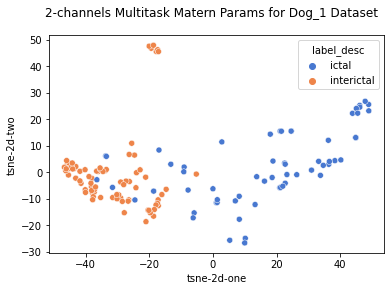

In [11]:
sns.scatterplot(data=embeddings.query("label_desc != 'test'"),
                x='tsne-2d-one', y='tsne-2d-two',
                hue="label_desc", palette="muted", legend=True)
plt.suptitle("2-channels Multitask Matern Params for Dog_1 Dataset")
plt.show()


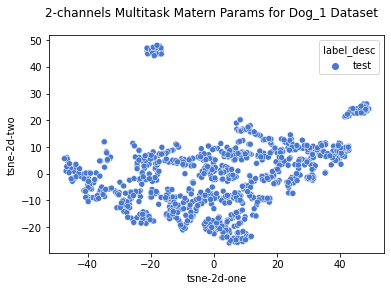

In [12]:
sns.scatterplot(data=embeddings.query("label_desc == 'test'"),
                x='tsne-2d-one', y='tsne-2d-two',
                # hue_order=hue_order,
                hue="label_desc", palette="muted", legend=True)
plt.suptitle("2-channels Multitask Matern Params for Dog_1 Dataset")
plt.show()


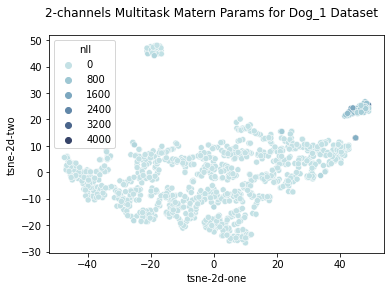

In [13]:
cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)

sns.scatterplot(data=embeddings,
                x='tsne-2d-one', y='tsne-2d-two',
                # hue_order=hue_order,
                hue="nll", palette=cmap, legend=True)
plt.suptitle("2-channels Multitask Matern Params for Dog_1 Dataset")
plt.show()

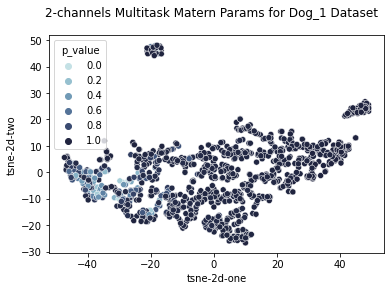

In [14]:
sns.scatterplot(data=embeddings,
                x='tsne-2d-one', y='tsne-2d-two',
                # hue_order=hue_order,
                hue="p_value", palette=cmap, legend=True)
plt.suptitle("2-channels Multitask Matern Params for Dog_1 Dataset")
plt.show()

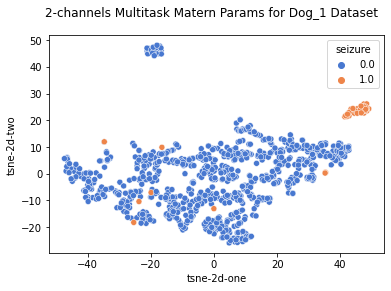

In [15]:
sns.scatterplot(data=embeddings.query("label_desc == 'test'"),
                x='tsne-2d-one', y='tsne-2d-two',
                # hue_order=hue_order,
                hue="seizure", palette="muted", legend=True)
plt.suptitle("2-channels Multitask Matern Params for Dog_1 Dataset")
plt.show()

## Evaluate anomaly detection

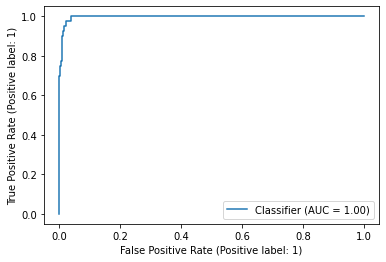

In [17]:
test_embeddings = embeddings.query("label_desc == 'test'")
RocCurveDisplay.from_predictions(test_embeddings['seizure'], test_embeddings['nll'])